<a href="https://colab.research.google.com/github/dominique-nshimyimana/Car-State/blob/master/series_car_state_action_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Car State-Action Prection 
#Colab: TensorFlow and GoogleDrive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

In [27]:
from google.colab import drive
mounted = '/drive'
drive.mount(mounted)

Mounted at /drive


# NN state Evaluation

In [0]:
import tensorflow as tf
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay


class NeuralDynamics(Model):

    def __init__(self, input_size, out_size, training=False):

        super(NeuralDynamics, self).__init__()

        self.training = training
        self.out_size = out_size
        if type(input_size) is tuple:
          self.state_size = input_size[0]
          self.action_size = input_size[1]
        else:
          self.state_size = input_size
          self.action_size = out_size

        self.layer1 = Dense(300, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l1(0.1))
        self.layer2 = Dense(300, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l1(0.1))

        self.layer_state1a = Dense(256, activation=tf.nn.relu)

        self.layer_state1 = Dense(128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l1(0.1))

        self.layer_state1b = Dense(64, activation=tf.nn.relu)
        self.layer_state1c = Dense(32, activation=tf.nn.relu)

        self.layer_state2 = Dense(self.out_size, kernel_regularizer=tf.keras.regularizers.l1(0.1))

        self.dropout = Dropout(rate=0.2)

        self.flatten = Flatten()

    @tf.function
    def call(self, inputs):

        #state, action = inputs
        #if type(self.input_size) is tuple and self.state_size[0] != state.shape[0]:
        #  missing_zeros = self.state_size[0]-state.shape[0]
        #  paddings = tf.constant([[missing_zeros, 0], [0, 0]])
        #  state = tf.pad(state, paddings, "CONSTANT")

        x = inputs  # f.concat((state, action), axis=1)
        x = self.layer1(x)
        if self.training:
            x = self.dropout(x)
        x = self.layer2(x)
        if self.training:
            x = self.dropout(x)
        x = self.flatten(x)

        x = self.layer_state1a(x)

        x = self.layer_state1(x)
        if self.training:
            x = self.dropout(x)

        x = self.layer_state1b(x)
        x = self.layer_state1c(x)
        
        state = self.layer_state2(x)
        return state

# Prepare Data

In [0]:
# Load dat from folder
# CSV form: Dataset
# Timestamp, x, y, yaw, xvel, yvel, omega, accel, brake, steering
def load_states_actions(data_dir, cutoff_beginning = 300, cutoff_end = 1000, norm=True, scale=False):
  data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and ".directory" not in f]

  xs_states = []
  xs_actions = []
  ys = []

  for f in data_files:
    print(f)
    data = np.loadtxt(f, delimiter=', ', skiprows=1, dtype=np.float32)[cutoff_beginning:-cutoff_end, :]
    x_states = [data[i, 1:-3] for i in range(len(data))]
    x_actions = [data[i, -3:] for i in range(len(data))]
    y = x_states[1:]
    x_states, x_actions = x_states[:-1], x_actions[:-1]
    xs_states += x_states
    xs_actions += x_actions
    ys += y

  xs_states = np.vstack(xs_states)
  xs_actions = np.vstack(xs_actions)
  ys = np.vstack(ys)

  if scale:
    scaler = MinMaxScaler()
    xs_states = scaler.fit_transform(xs_states)
    xs_actions = scaler.fit_transform(xs_actions)

  if norm:
    brake_mask = xs_actions[:, 0] < xs_actions[:, 1]
    xs_actions[brake_mask, 0] = -xs_actions[brake_mask, 1]
    xs_actions = xs_actions[:, [0, 2]]

    xs_states_shape_before = xs_states.shape[0]
    xs_std_before = np.std(xs_states, axis=0)
    ys_std_before = np.std(ys, axis=0)

    inliers = ~np.any(abs(xs_states - np.mean(xs_states, axis=0)) >= 3*np.std(xs_states, axis=0), axis=1)
    xs_states = xs_states[inliers]
    xs_actions = xs_actions[inliers]
    ys = ys[inliers]

    inliers = ~np.any(abs(ys - np.mean(ys, axis=0)) >= 3*np.std(ys, axis=0), axis=1)
    xs_states = xs_states[inliers]
    xs_actions = xs_actions[inliers]
    ys = ys[inliers]

  return xs_states, xs_actions, ys

# convert an array of values into a dataset matrix
# State(s) at a given time t (or time series until t) and Y is the state at the next time (t + 1).
def create_dataset(dataset, look_back=1):
  
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		dataX.append(np.squeeze(dataset[i:i+look_back])) #dataset[i:(i+look_back), 0]
		dataY.append(dataset[i + look_back]) #dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

def takeSlice(arr, fr, to, name):
  result = arr[:,fr:to,:]
  print(name + ": start at " + str(fr) + " - shape: " + str(result.shape))
  return result

### Load Data

In [30]:
# Load Data
data_dir = "/drive/My Drive/neuronyte_logging"
xs_states, xs_actions, ys = load_states_actions(data_dir=data_dir)

/drive/My Drive/neuronyte_logging/NeuroNyte_1585748620.316643
/drive/My Drive/neuronyte_logging/NeuroNyte_1585745385.311904


### Preparre and Look at Data ...

In [103]:
# Split data
x_states_train, x_states_test, x_actions_train, x_actions_test = train_test_split(xs_states, xs_actions, shuffle=False, test_size=0.10)

# How many steps/state in back from t and # How many steps/state in future/forward from t
look_back = 1
look_forward = 1

# reshape into X=t and Y=t+1 for states
x_states_, y_ = create_dataset(x_states_train, look_back)
x_states_test, y_test = create_dataset(x_states_test, look_back)

# Use only n data now
n = 25000
#Xvis, yvis = x_states_[:n:], y_[:n:]
X, y = x_states_, y_

# Visualize X=t and Y=t+1
t = 3
print(X[t])
print(y[t+1])
print(X.shape, y.shape)
Xshape, yshape = X.shape, y.shape

[0.      0.      2.96706 0.      0.      0.     ]
[0.      0.      2.96706 0.      0.      0.     ]
(945111, 6) (945111, 6)


########## Look into Data ##########


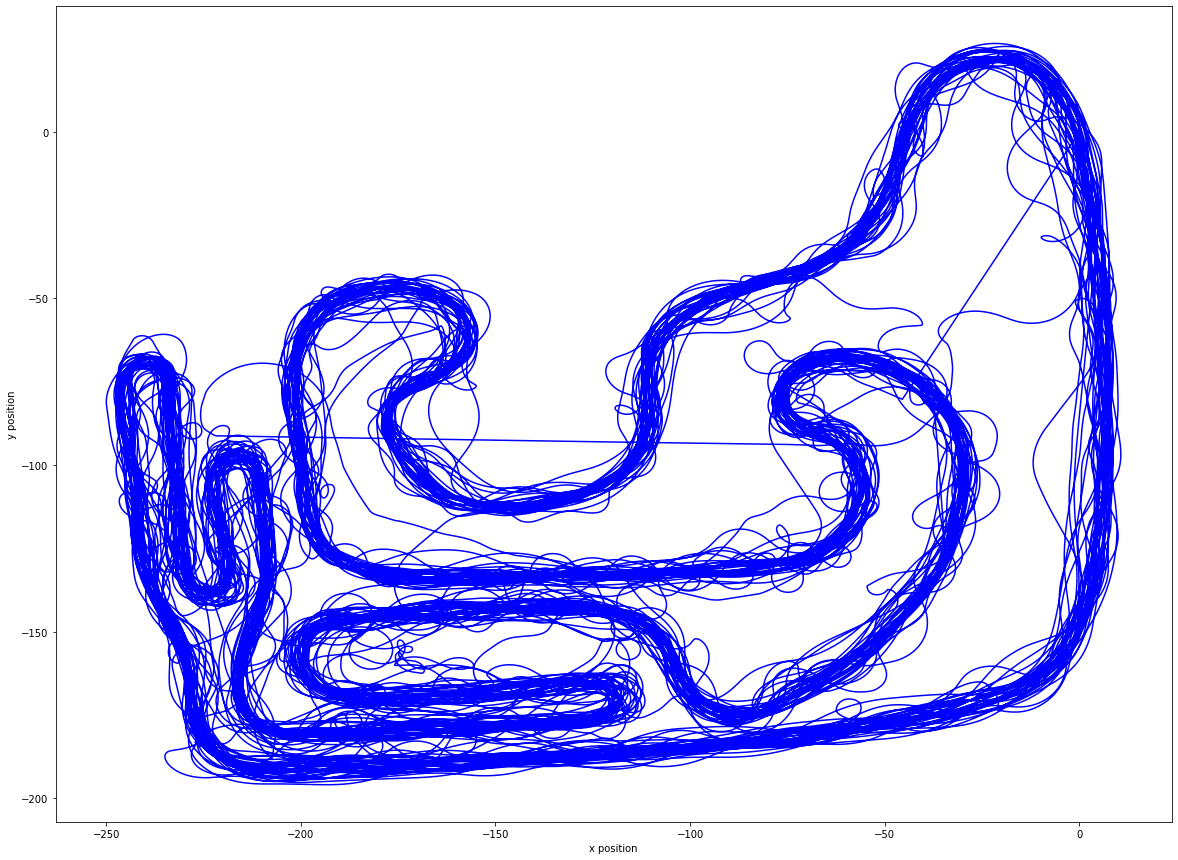

In [102]:
print('#'*10, "Look into Data",'#'*10)
# x, y, ... from shape=(...,...6)
#X = x_states_train[0:n:1]
labels = y[:,:2]  #y_[:,:,:2]
#option  = X[:,:2]

plt.plot(*zip(*labels), 'b')
#plt.plot(*zip(*option),'r')
plt.ylabel('y position')
plt.xlabel('x position')

fig = plt.gcf()
fig.set_size_inches(20, 15)
plt.show()

# Initialize Model

In [104]:
batchsize = 1000
decay = ExponentialDecay(0.0004, 20000, 0.99)
cosineDecay = tf.keras.experimental.CosineDecayRestarts(0.0004, 30, t_mul=2.0, m_mul=1.0, alpha=0.00001)
optimizer = tf.keras.optimizers.Adam(learning_rate=cosineDecay)

model = NeuralDynamics((look_back, 6),out_size=6, training=True)
EPOCHS = 200
print('Model Initialized!')

Model Initialized!


# Training

In [105]:
#print(x_states_train.shape, x_actions_train.shape, y_train.shape)
#np.array(y_test).reshape(y_test.shape[0], 1, y_test.shape[-1])
print('X: ', X.shape, 'Y: ', y.shape)

# checkpoint
'''
filepath=join(mounted, "My Drive/NeuralModel/lstm_car_state/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
history = model.fit(X, Y, epochs=EPOCHS, validation_split=0.2, verbose=1, batch_size=20000, callbacks=callbacks_list)
'''
#history = model.fit(X, Y, epochs=EPOCHS, validation_split=0.2, verbose=1, batch_size=batchsize, metrics=['mse', 'mae', 'mape', 'cosine']))

model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.3, verbose=1, batch_size=batchsize, shuffle = False)

model.save(join(mounted, 'My Drive/NeuralModel/lstm_car_state/seriesv1'))

X:  (945111, 6) Y:  (945111, 6)
Epoch 1/200
662/662 [==============================] - 3s 4ms/step - loss: 993.5771 - val_loss: 483.7902
Epoch 2/200
662/662 [==============================] - 3s 4ms/step - loss: 493.4501 - val_loss: 396.1631
Epoch 3/200
662/662 [==============================] - 3s 4ms/step - loss: 370.5987 - val_loss: 361.4868
Epoch 4/200
662/662 [==============================] - 3s 4ms/step - loss: 373.6778 - val_loss: 291.6188
Epoch 5/200
662/662 [==============================] - 3s 4ms/step - loss: 275.3311 - val_loss: 257.2298
Epoch 6/200
662/662 [==============================] - 3s 4ms/step - loss: 330.8954 - val_loss: 624.7866
Epoch 7/200
662/662 [==============================] - 3s 4ms/step - loss: 353.2675 - val_loss: 244.8004
Epoch 8/200
662/662 [==============================] - 3s 4ms/step - loss: 234.0657 - val_loss: 211.8576
Epoch 9/200
662/662 [==============================] - 3s 4ms/step - loss: 202.6961 - val_loss: 183.4973
Epoch 10/200
662/662 [=

### Evaluatte

In [0]:
eval_result = model.evaluate(object, x_states_test, y_test, batch_size = 1, verbose = 1, sample_weight = NULL, steps = NULL)


# Testing

In [107]:
Xtest, ytest = x_states_test[:n:], y_test[:n:]

print('Xtest: ', Xtest.shape, 'ytest: ', ytest.shape)
#result = model.predict((x_states_test, x_actions_test))
yhat = model.predict(Xtest, batch_size=1)
print('Result: ', yhat.shape)

Xtest:  (25000, 6) ytest:  (25000, 6)
Result:  (25000, 6)


# Visualization of result

########## Look into Data ##########


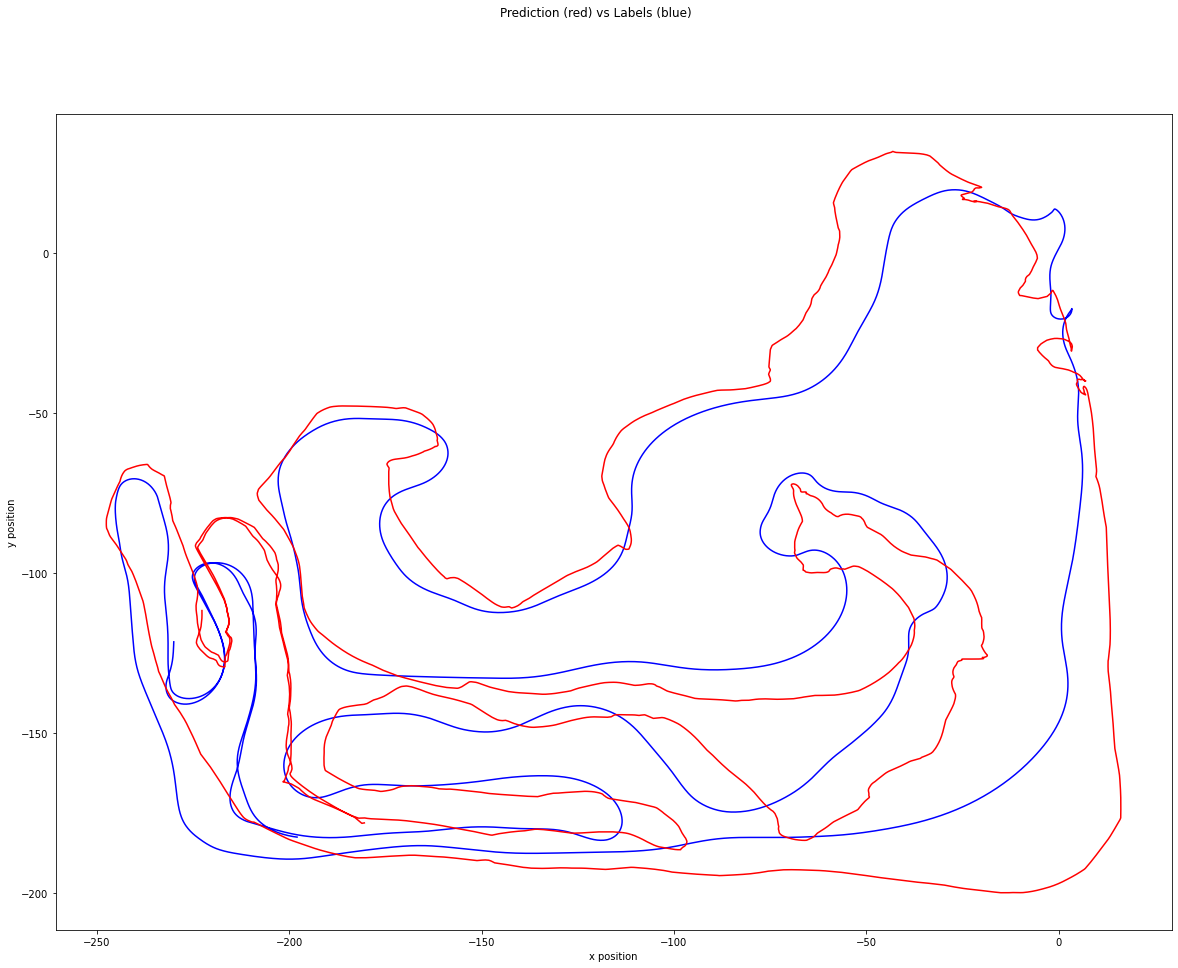

In [110]:
print('#'*10, "Look into Data",'#'*10)
# x, y, ... from shape=(...,...6)
labels = ytest[:,:2]  #y_[:,:,:2]
predict  = 1.8*yhat[:,:2]

plt.plot(*zip(*labels), 'b')
plt.plot(*zip(*predict),'r')
plt.ylabel('y position')
plt.xlabel('x position')
plt.suptitle("Prediction (red) vs Labels (blue)")
plt.gcf().set_size_inches(20, 15)
plt.show()

### Fine tune

In [0]:
# Use small batch
batchsize = 2
EPOCHS = 2
decay = ExponentialDecay(0.0004, 20000, 0.99)
optimizer_exp = tf.keras.optimizers.Adam(learning_rate=decay)

model.compile(optimizer_exp, loss=tf.keras.losses.MeanSquaredError())  # metrics=['mse', 'mae', 'mape', 'cosine'])
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.3, verbose=1, batch_size=batchsize, shuffle = False)

model.save(join(mounted, 'My Drive/NeuralModel/lstm_car_state/seriesv2'))

Epoch 1/2
330789/330789 [==============================] - 1030s 3ms/step - loss: 4.5895 - val_loss: 3240.7205
Epoch 2/2
 29351/330789 [=>............................] - ETA: 12:50 - loss: 1.2319

In [0]:
print('Forcast after fine tuning ...')
yhat = model.predict(Xtest)

# Vis after tuning ...
labels = ytest[:,:2]  #y_[:,:,:2]
predict  = yhat[:,:2]

plt.plot(*zip(*labels), 'b')
plt.plot(*zip(*predict),'r')
plt.ylabel('y position')
plt.xlabel('x position')
plt.suptitle("yy pasition as one feature")
plt.gcf().set_size_inches(20, 15)
plt.show()

Docs

*   https://keras.rstudio.com/reference/evaluate.html
*   https://www.tensorflow.org/guide/keras/train_and_evaluate
*   https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

